In [2]:
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from matplotlib.patches import Circle
from astropy import units as u
from matplotlib.colors import LogNorm
import matplotlib.animation

In [3]:
def getImage(path):
  filename = get_pkg_data_filename(path)
  hdu = fits.open(filename)
  
  image_data = hdu[0].data
  image_header = hdu[0].header

  return image_data, image_header

In [4]:
def plotHist(image_data, nbins=200):
  # flatten means: we put our 2d array in a 1d array
  histogram = plt.hist(image_data.flatten(), nbins)

  plt.xlabel('Pixel Content')
  plt.ylabel('Number of Pixels')
  plt.yscale('log')
  plt.show()

In [5]:
def plotImage(image_header, image_data):
  fig = plt.figure()

  wcs = WCS(image_header)
  ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
  fig.add_axes(ax)

  # Now with an other colormap and in logscale
  img = ax.imshow(image_data, cmap='afmhot', norm=LogNorm())

  ax.set_xlabel('RA')
  ax.set_ylabel('Dec')

  ax.grid(color='white', ls='solid')

  # Set the limits of the colorbar and a label
  cb = fig.colorbar(img)
  # img.set_clim(1.1*np.min(image_data), np.max(image_data))
  cb.set_label('Counts')

  plt.show()

In [6]:
def subtractImages(NB_image_data, BB_image_data, scale_factor):
  subtracted_arr = BB_image_data * scale_factor
  return np.subtract(NB_image_data, subtracted_arr)

In [17]:
Ha_data, Ha_header = getImage('data/rim_Ha_wcs.fits')
R_data, R_header = getImage('data/rim_R_wcs.fits')
SII_data, SII_header = getImage('data/rim_[SII]_wcs.fits')

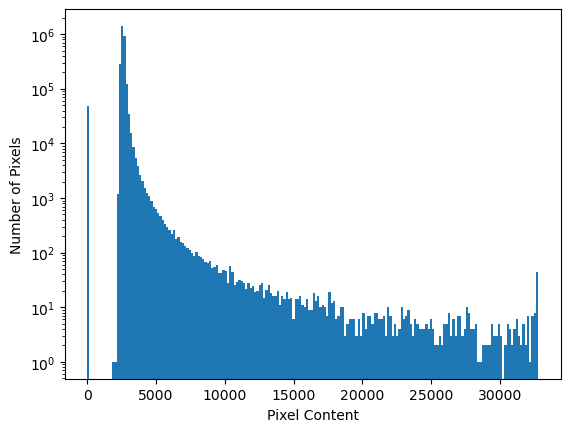

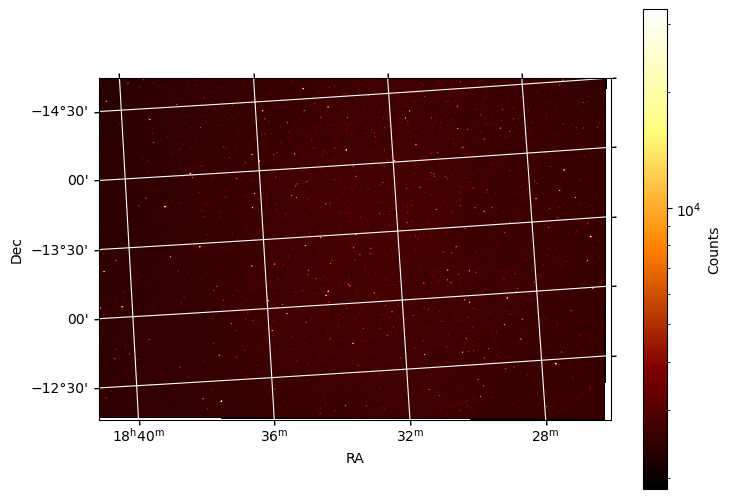

In [26]:
plotHist(R_data)
plotImage(R_header, R_data)

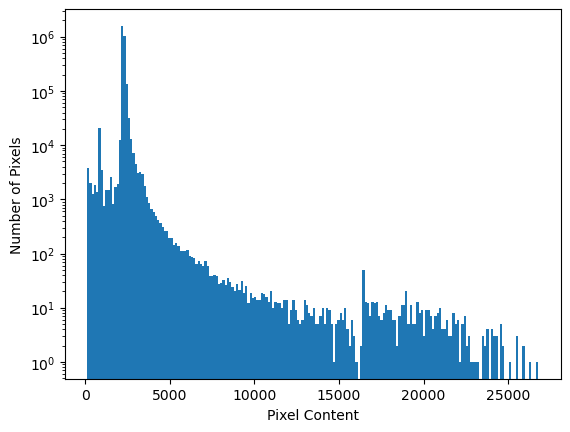

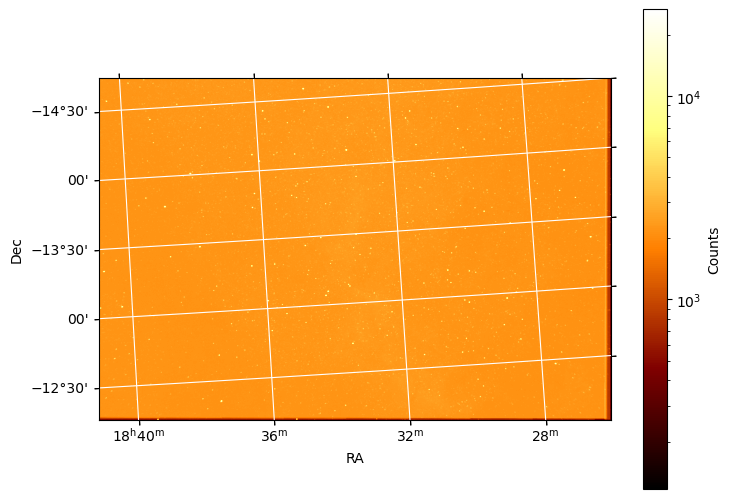

In [27]:
difference_image_data = subtractImages(Ha_data, R_data, 0.5)
plotHist(difference_image_data)
plotImage(R_header, difference_image_data)

In [34]:
plt.close('all')
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    scale_factor = 0.5 + t*0.05
    # Now with an other colormap and in logscale
    img = ax.imshow(
        Ha_data - scale_factor*R_data, cmap='afmhot', 
        # vmin=np.min(Ha_data - R_data), vmax=np.max(Ha_data), 
        # vmin=-30000, vmax=30000, 
        norm=LogNorm(vmin=1, vmax=np.max(Ha_data))
    )
    plt.text(0, -10, f"mu = {scale_factor}")
    if t == 1: fig.colorbar(img)

matplotlib.animation.FuncAnimation(fig, animate, frames=25)

In [29]:
def calculateSkew(image_data):
  data = np.array(image_data.flatten())
  N = len(data)
  mean = np.mean(data)   # Mean of the data
  std_dev = np.std(data, ddof=1)
  
  # Compute skewness
  return np.sum(((data - mean) / std_dev) ** 3) / (N - 1)

#Calculates skewness using function from paper
def calculateSkewLeo(data):
    skewness = 0 #Temporary
    pixelCount = np.size(data)
    mean = data.mean()
    std = data.std()
    for row in range(0, len(data)):
        for col in range(0, len(data[0])):
            skewness += ((data[row, col] - mean)/std)**3
    skewness = skewness/(pixelCount-1)
    return skewness

In [30]:
plt.ioff()
fig, ax = plt.subplots()

nbins=200

def animate(t):
  plt.cla()
  # Now with an other colormap and in logscale
  plt.hist((Ha_data - t*0.1*R_data).flatten(), nbins)
  plt.text(0, 1, f"mu = {round(t*0.1, 2)}", ha='left', va='top', transform=ax.transAxes)
  plt.text(0.2, 1, f"skew = {round(calculateSkew(Ha_data - t*0.1*R_data), 2)}", ha='left', va='top', transform=ax.transAxes)
  plt.yscale('log')

matplotlib.animation.FuncAnimation(fig, animate, frames=20)

In [31]:
def getSkews(NB_image_data, BB_image_data, scale_factor_linspace):
  skews = []
  for mu in scale_factor_linspace:
    skews.append(calculateSkew(NB_image_data - mu*BB_image_data))
  return skews

In [32]:
scale_factors = np.linspace(0, 2, 100)
Ha_R_skews = getSkews(Ha_data, R_data, np.linspace(0, 2, 100))

[19.573679118893374, 19.647991147211798, 19.72484241159732, 19.804353104399144, 19.886701441859195, 19.97198827502911, 20.060402872320843, 20.152047466307287, 20.247169349293127, 20.34583345277736, 20.448356145127427, 20.554854855650024, 20.66553543101218, 20.780658978731136, 20.90047831719659, 21.025170281129213, 21.15499459652499, 21.29028282848517, 21.43123806063428, 21.578182187424773, 21.731348685948788, 21.891082936520135, 22.057593548848345, 22.231196891300872, 22.41209190293846, 22.600547980405885, 22.79663834432967, 23.000530158781693, 23.212126717274092, 23.431352036137834, 23.65781100029392, 23.890986920792898, 24.13002325445653, 24.37364900173001, 24.62012620887427, 24.867186417988236, 25.11167976061, 25.349566668589283, 25.575801826302023, 25.783900372976202, 25.96612855262508, 26.112942816417583, 26.213199813909085, 26.25412047348878, 26.2214834153554, 26.09994822749096, 25.873939639264076, 25.52840459507785, 25.05018272345502, 24.429269047465272, 23.660203795107964, 22.7

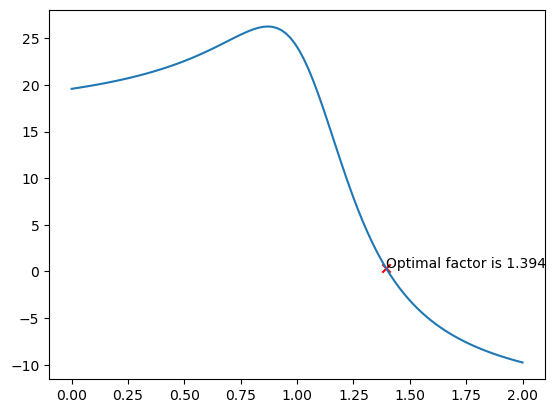

In [33]:
def find_nearest_zero(array, l=0, b=None):
    if b is None:
        b = len(array)
    
    # Base case: If there is one element left, return its index
    if b - l == 1:
        return l
    
    # Find the midpoint of the current range
    mid = (l + b) // 2

    # Check the midpoint value
    if array[mid] == 0:
        return mid  # Found exact zero
    elif array[mid] > 0:
        # Look in the lower half (towards smaller absolute values)
        return find_nearest_zero(array, l=mid, b=b)
    else:
        # Look in the upper half (towards smaller absolute values)
        return find_nearest_zero(array, l=l, b=mid)

plt.close('all')
plt.plot(scale_factors, Ha_R_skews)
pt = [scale_factors[find_nearest_zero(Ha_R_skews)], Ha_R_skews[find_nearest_zero(Ha_R_skews)]]
plt.scatter(pt[0], pt[1], c='r', marker='x')
plt.text(pt[0], pt[1], f'Optimal factor is {round(pt[0], 3)}')
print(Ha_R_skews)
plt.show()